<a href="https://www.kaggle.com/code/shwetakolekar/retailrocket-recommender-system?scriptVersionId=163517518" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

import datetime
import calendar

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from surprise import Reader,Dataset,SVD
from surprise.model_selection import cross_validate,GridSearchCV
import random




*           A recommender system  is a software designed to suggest items or content to users based on their preferences, behavior, or characteristics.The goal is to help users discover items that they might be interested in, thereby enhancing user experience and increasing engagement.Also increasing the sales.RetailRocket is an e-commerce platform, and it provides personalized recommendation solutions for e-commerce bussinesses.


* The Retailrocket dataset comes in three files:

    1 .events.csv: This file contains the visitor-item interaction data
    2 .item_properties.сsv: This file contains item properties
    3 .category_tree.csv: This file contains the category tree
    
* Here are the steps we perform in this model
    
    1. Understand the Dataset
    2. Exploratory Data Analysis
    3. Feature Engineering
    4. Data Preprocessig
    5. Tune Hyperparameters
    6. Training model on SVD model
    7. Evaluate the Recommendor System
    
    
*  In recommendor system their are two types :
   1. Content based filtering
   2. Collaborative filtering
   
                                          
*  Here We used Collaborative filtering .In that We used SVD matrix factorization technique.Matrix factorization which separates a matrix into two other matrices.

    

# 1. Data Understanding

In [2]:

e_event=pd.read_csv('/kaggle/input/ecommerce-dataset/events.csv')
e_event.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [3]:
# Here convert timestamp into datetime format

e_event['event_datetime']=pd.to_datetime(e_event['timestamp'],unit='ms')
e_event

,timestamp,visitorid,event,itemid,transactionid,event_datetime
0,1433221332117,257597,view,355908,NaN,2015-06-02 05:02:12.117
1,1433224214164,992329,view,248676,NaN,2015-06-02 05:50:14.164
2,1433221999827,111016,view,318965,NaN,2015-06-02 05:13:19.827
3,1433221955914,483717,view,253185,NaN,2015-06-02 05:12:35.914
4,1433221337106,951259,view,367447,NaN,2015-06-02 05:02:17.106
...,...,...,...,...,...,...
2756096,1438398785939,591435,view,261427,NaN,2015-08-01 03:13:05.939
2756097,1438399813142,762376,view,115946,NaN,2015-08-01 03:30:13.142
2756098,1438397820527,1251746,view,78144,NaN,2015-08-01 02:57:00.527
2756099,1438398530703,1184451,view,283392,NaN,2015-08-01 03:08:50.703


In [4]:
e_event.shape

(2756101, 6)

In [5]:
e_event.isnull().sum()

timestamp               0
visitorid               0
event                   0
itemid                  0
transactionid     2733644
event_datetime          0
dtype: int64

In [6]:
e_event.event.value_counts().reset_index()

,event,count
0,view,2664312
1,addtocart,69332
2,transaction,22457


In [7]:
#checking out how much timespam dataset is present here

print('Start Date of Dataset: ' ,e_event['event_datetime'].min())
print('End Date of Dataset: ' ,e_event['event_datetime'].max())
      

Start Date of Dataset:  2015-05-03 03:00:04.384000
End Date of Dataset:  2015-09-18 02:59:47.788000


In [8]:
#concatenate two item files and creat one e_item file.

e_items1=pd.read_csv('/kaggle/input/ecommerce-dataset/item_properties_part1.csv')
e_items2 = pd.read_csv('/kaggle/input/ecommerce-dataset/item_properties_part2.csv')
e_items=pd.concat([e_items1,e_items2])
e_items

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513
...,...,...,...,...
9275898,1433646000000,236931,929,n12.000
9275899,1440903600000,455746,6,150169 639134
9275900,1439694000000,347565,686,610834
9275901,1433646000000,287231,867,769062


In [9]:
e_items['event_datetime']=pd.to_datetime(e_items['timestamp'],unit='ms')
e_items

,timestamp,itemid,property,value,event_datetime
0,1435460400000,460429,categoryid,1338,2015-06-28 03:00:00
1,1441508400000,206783,888,1116713 960601 n277.200,2015-09-06 03:00:00
2,1439089200000,395014,400,n552.000 639502 n720.000 424566,2015-08-09 03:00:00
3,1431226800000,59481,790,n15360.000,2015-05-10 03:00:00
4,1431831600000,156781,917,828513,2015-05-17 03:00:00
...,...,...,...,...,...
9275898,1433646000000,236931,929,n12.000,2015-06-07 03:00:00
9275899,1440903600000,455746,6,150169 639134,2015-08-30 03:00:00
9275900,1439694000000,347565,686,610834,2015-08-16 03:00:00
9275901,1433646000000,287231,867,769062,2015-06-07 03:00:00


In [10]:
e_category = pd.read_csv('/kaggle/input/ecommerce-dataset/category_tree.csv')
e_category

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0
...,...,...
1664,49,1125.0
1665,1112,630.0
1666,1336,745.0
1667,689,207.0


In [11]:
e_category.shape

(1669, 2)

In [12]:
e_items.loc[(e_items.property == 'categoryid')&(e_items.value== '570')].head()

,timestamp,itemid,property,value,event_datetime
88665,1435460400000,345903,categoryid,570,2015-06-28 03:00:00
306182,1431831600000,73077,categoryid,570,2015-05-17 03:00:00
614622,1431226800000,165050,categoryid,570,2015-05-10 03:00:00
689859,1435460400000,201959,categoryid,570,2015-06-28 03:00:00
898776,1431226800000,221816,categoryid,570,2015-05-10 03:00:00


#  2.Exploratory Data Analysis

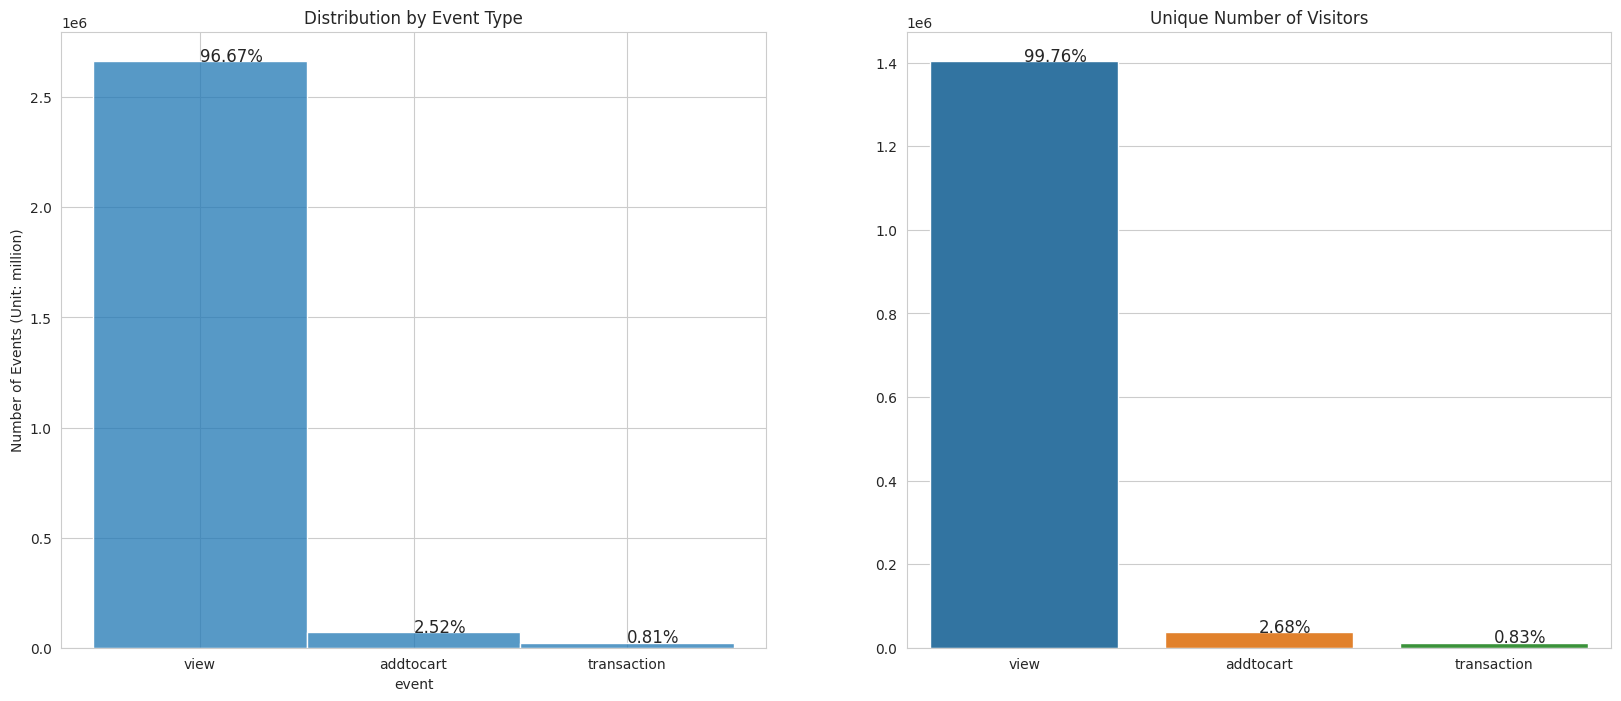

In [13]:
# distribution by event

totalcases=e_event.shape[0]
sns.set_style('whitegrid')

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,8))
sns.histplot(x = 'event', data = e_event, bins = 3, ax = ax1)
ax1.set_ylabel('Number of Events (Unit: million)')
ax1.set_title('Distribution by Event Type')
for x, counts in zip(e_event['event'].unique().tolist(), e_event['event'].value_counts().tolist()):
    text=str(round((counts/totalcases)*100,2)) +'%'
    ax1.text(x, counts, text, fontsize=12)
    

# unique number of visitors by event

events = e_event['event'].unique().tolist()
unique_num = []
ratios = []
for event in events:
    uni_visit = len(e_event['visitorid'][e_event['event']==event].unique())
    unique_num.append(uni_visit)
    ratios.append(uni_visit/len(set(e_event['visitorid'])))

sns.barplot(x = events, y = unique_num, ax = ax2)

ratio_p = [str(round(r*100,2)) + '%' for r in ratios]
for e, c, r in zip(range(3), unique_num, ratio_p):
    ax2.text(e, c, r, fontsize=12)
    
ax2.set_title('Unique Number of Visitors')
plt.show()

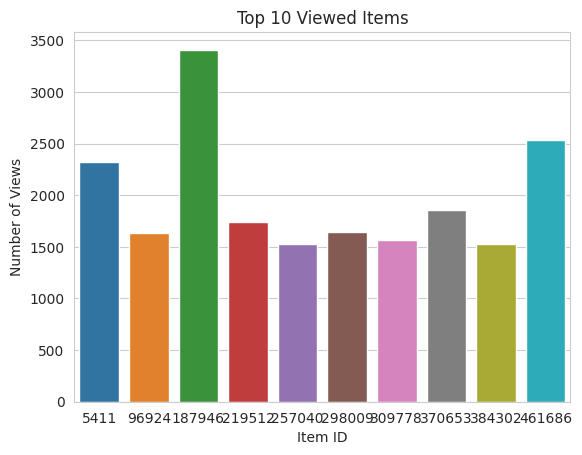

<Figure size 1000x600 with 0 Axes>

In [14]:
#Top 10 Viewed items
top_viewed_items=e_event[e_event['event']=='view']['itemid'].value_counts().head(10)
sns.barplot(x=top_viewed_items.index , y=top_viewed_items.values)
plt.title('Top 10 Viewed Items')
plt.xlabel('Item ID')
plt.ylabel('Number of Views')
plt.figure(figsize=(10,6))
plt.show()

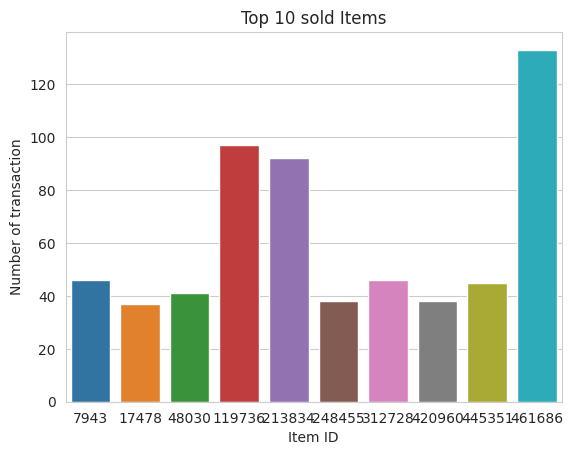

<Figure size 1000x600 with 0 Axes>

In [15]:
#Top 10 sold items
top_sold_items=e_event[e_event['event']=='transaction']['itemid'].value_counts().head(10)
sns.barplot(x=top_sold_items.index , y=top_sold_items.values)
plt.title('Top 10 sold Items')
plt.xlabel('Item ID')
plt.ylabel('Number of transaction')
plt.figure(figsize=(10,6))
plt.show()

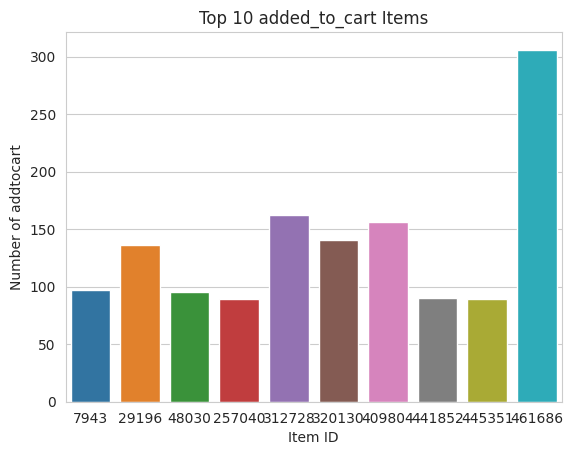

<Figure size 1000x600 with 0 Axes>

In [16]:
#Top 10 added_to_cart items
top_added_to_cart_items=e_event[e_event['event']=='addtocart']['itemid'].value_counts().head(10)
sns.barplot(x=top_added_to_cart_items.index , y=top_added_to_cart_items.values)
plt.title('Top 10 added_to_cart Items')
plt.xlabel('Item ID')
plt.ylabel('Number of addtocart')
plt.figure(figsize=(10,6 ) )
plt.show()

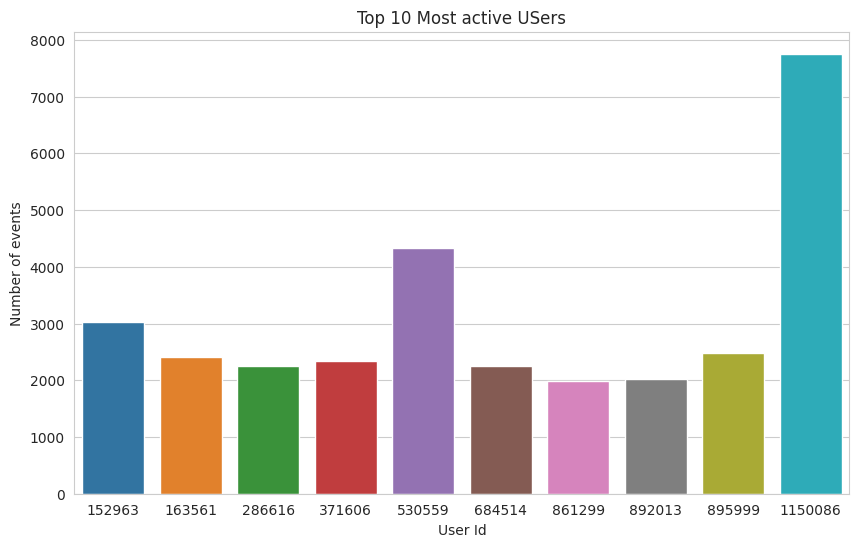

In [17]:
#Top 10 most active users
top_active_users=e_event['visitorid'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_active_users.index, y=top_active_users.values)
plt.title('Top 10 Most active USers')
plt.xlabel('User Id')
plt.ylabel('Number of events')
plt.show()

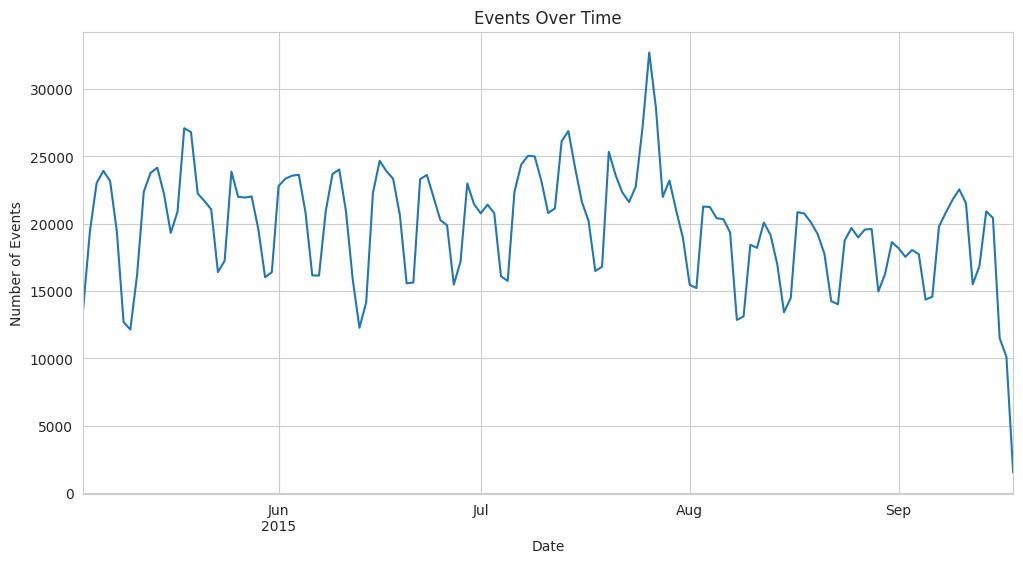

In [18]:
# Events over time
events_daily = e_event.resample('D', on='event_datetime').count()
plt.figure(figsize=(12, 6))
events_daily['event'].plot()
plt.title('Events Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.show()

*  **The plot shows the trend or pattern of how the number of events changes over time. Each point on the line represents the count of events on a specific day.**

In [19]:
print('number of unique purchases: ', len(e_event[e_event.transactionid.notnull()].visitorid.unique()))
print('Total purchases : ', len(e_event[e_event.transactionid.notnull()]))

number of unique purchases:  11719
Total purchases :  22457


In [20]:
#I covert the timestamp into readable time format.
e_items['event_datetime']=pd.to_datetime(e_items['timestamp'],unit='ms')
e_items

,timestamp,itemid,property,value,event_datetime
0,1435460400000,460429,categoryid,1338,2015-06-28 03:00:00
1,1441508400000,206783,888,1116713 960601 n277.200,2015-09-06 03:00:00
2,1439089200000,395014,400,n552.000 639502 n720.000 424566,2015-08-09 03:00:00
3,1431226800000,59481,790,n15360.000,2015-05-10 03:00:00
4,1431831600000,156781,917,828513,2015-05-17 03:00:00
...,...,...,...,...,...
9275898,1433646000000,236931,929,n12.000,2015-06-07 03:00:00
9275899,1440903600000,455746,6,150169 639134,2015-08-30 03:00:00
9275900,1439694000000,347565,686,610834,2015-08-16 03:00:00
9275901,1433646000000,287231,867,769062,2015-06-07 03:00:00


In [21]:
e_items.shape

(20275902, 5)

In [22]:
merged_events=e_event.merge(e_items, on=['itemid','timestamp'],how='left').merge(e_category,left_on='property', right_on='categoryid',how='left')
merged_events.head()

,timestamp,visitorid,event,itemid,transactionid,event_datetime_x,property,value,event_datetime_y,categoryid,parentid
0,1433221332117,257597,view,355908,NaN,2015-06-02 05:02:12.117,NaN,NaN,NaT,NaN,NaN
1,1433224214164,992329,view,248676,NaN,2015-06-02 05:50:14.164,NaN,NaN,NaT,NaN,NaN
2,1433221999827,111016,view,318965,NaN,2015-06-02 05:13:19.827,NaN,NaN,NaT,NaN,NaN
3,1433221955914,483717,view,253185,NaN,2015-06-02 05:12:35.914,NaN,NaN,NaT,NaN,NaN
4,1433221337106,951259,view,367447,NaN,2015-06-02 05:02:17.106,NaN,NaN,NaT,NaN,NaN


In [23]:
merged_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 11 columns):
 #   Column            Dtype         
---  ------            -----         
 0   timestamp         int64         
 1   visitorid         int64         
 2   event             object        
 3   itemid            int64         
 4   transactionid     float64       
 5   event_datetime_x  datetime64[ns]
 6   property          object        
 7   value             object        
 8   event_datetime_y  datetime64[ns]
 9   categoryid        float64       
 10  parentid          float64       
dtypes: datetime64[ns](2), float64(3), int64(3), object(3)
memory usage: 231.3+ MB


In [24]:
#Top categories by views
top_categories_views = merged_events[merged_events['event'] == 'view']['parentid'].value_counts().head(10)

if not top_categories_views.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_categories_views.index, y=top_categories_views.values)
    plt.title('Top 10 Categories by Views')
    plt.xlabel('Category ID')
    plt.ylabel('Number of Views')
    plt.show()
else:
    print("No data available for Top Categories by Views")

No data available for Top Categories by Views


In [25]:
#Top categories by transactions
top_categories_transactions = merged_events[merged_events['event'] == 'transaction']['parentid'].value_counts().head(10)

if not top_categories_transactions.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_categories_transactions.index, y=top_categories_transactions.values)
    plt.title('Top 10 Categories by Transactions')
    plt.xlabel('Category ID')
    plt.ylabel('Number of Transactions')
    plt.show()
else:
    print("No data available for Top Categories by Transactions")

No data available for Top Categories by Transactions


In [26]:
def findDay(x):
    day = calendar.day_name[x.weekday()]
    return day

In [27]:
# I found events in day ,year,month,day,hour,minute format.
e_event['day_of_week']=e_event['event_datetime'].map(findDay)
e_event['year']=e_event['event_datetime'].map(lambda x:x.year)
e_event['Month']=e_event['event_datetime'].map(lambda x:x.month)
e_event['Day'] = e_event['event_datetime'].map(lambda x: x.day)
e_event['Hour'] = e_event['event_datetime'].map(lambda x: x.hour)
e_event['minute'] = e_event['event_datetime'].map(lambda x: x.minute)
e_event

,timestamp,visitorid,event,itemid,transactionid,event_datetime,day_of_week,year,Month,Day,Hour,minute
0,1433221332117,257597,view,355908,NaN,2015-06-02 05:02:12.117,Tuesday,2015,6,2,5,2
1,1433224214164,992329,view,248676,NaN,2015-06-02 05:50:14.164,Tuesday,2015,6,2,5,50
2,1433221999827,111016,view,318965,NaN,2015-06-02 05:13:19.827,Tuesday,2015,6,2,5,13
3,1433221955914,483717,view,253185,NaN,2015-06-02 05:12:35.914,Tuesday,2015,6,2,5,12
4,1433221337106,951259,view,367447,NaN,2015-06-02 05:02:17.106,Tuesday,2015,6,2,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...
2756096,1438398785939,591435,view,261427,NaN,2015-08-01 03:13:05.939,Saturday,2015,8,1,3,13
2756097,1438399813142,762376,view,115946,NaN,2015-08-01 03:30:13.142,Saturday,2015,8,1,3,30
2756098,1438397820527,1251746,view,78144,NaN,2015-08-01 02:57:00.527,Saturday,2015,8,1,2,57
2756099,1438398530703,1184451,view,283392,NaN,2015-08-01 03:08:50.703,Saturday,2015,8,1,3,8


In [28]:
e_event.describe()

,timestamp,visitorid,itemid,transactionid,event_datetime,year,Month,Day,Hour,minute
count,2.756101e+06,2.756101e+06,2.756101e+06,22457.000000,2756101,2756101.0,2.756101e+06,2.756101e+06,2.756101e+06,2.756101e+06
mean,1.436424e+12,7.019229e+05,2.349225e+05,8826.497796,2015-07-09 06:48:08.348103680,2015.0,6.771084e+00,1.538997e+01,1.279443e+01,2.969765e+01
min,1.430622e+12,0.000000e+00,3.000000e+00,0.000000,2015-05-03 03:00:04.384000,2015.0,5.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.433478e+12,3.505660e+05,1.181200e+05,4411.000000,2015-06-05 04:23:14.792000,2015.0,6.000000e+00,8.000000e+00,4.000000e+00,1.500000e+01
50%,1.436453e+12,7.020600e+05,2.360670e+05,8813.000000,2015-07-09 14:43:33.599000064,2015.0,7.000000e+00,1.500000e+01,1.600000e+01,3.000000e+01
75%,1.439225e+12,1.053437e+06,3.507150e+05,13224.000000,2015-08-10 16:45:05.168000,2015.0,8.000000e+00,2.300000e+01,2.000000e+01,4.500000e+01
max,1.442545e+12,1.407579e+06,4.668670e+05,17671.000000,2015-09-18 02:59:47.788000,2015.0,9.000000e+00,3.100000e+01,2.300000e+01,5.900000e+01
std,3.366312e+09,4.056875e+05,1.341954e+05,5098.996290,NaN,0.0,1.291455e+00,8.667102e+00,7.867598e+00,1.733134e+01


In [29]:
def get_time_periods(hour):
    if hour >= 3 and hour < 7:
        return 'Dawn'
    elif hour >=7 and hour < 12:
        return 'Morning'
    elif hour >=12 and hour < 16:
        return 'Afternoon'
    elif hour >=16 and hour< 22:
        return 'Evening'
    else:
        return 'Night'

In [30]:
#Day period wise event
e_event['Day period']=e_event['Hour'].map(get_time_periods)
e_event['Day period'].value_counts()

Day period
Evening      1078199
Night         765924
Dawn          494588
Afternoon     293490
Morning       123900
Name: count, dtype: int64

In [31]:
#Add-to-cart to transaction conversion rate

add_to_cart = e_event[e_event['event'] == 'addtocart']
transactions = e_event[e_event['event'] == 'transaction']
conversion_rate = len(transactions) / len(add_to_cart)

print(f"Add-to-cart to transaction conversion rate: {conversion_rate:.2%}")

Add-to-cart to transaction conversion rate: 32.39%


1 . **User-based features**: Extract information about user behavior, such as average time spent on the platform, average number of items viewed, and average number of items added to cart. We can also calculate the average time between actions (e.g., view, add to cart, and transaction).

2 . **Item-based features**: To calculate item popularity based on the number of views, add to carts, and transactions. Additionally, we can calculate the average time an item spends in the cart before being purchased or removed.

3 . **User-item interaction features**: Calculate the frequency of user-item interactions and the average time between interactions. These features will help determine how often a user interacts with a specific item and how much time passes between interactions.

4 .**Category-based features:** Calculate category popularity based on the number of views and transactions for items in each category. This information can be useful for identifying popular categories and understanding user preferences.

5 .**Timestamp-based features:** Extract information from timestamps, such as day of the week, hour of the day, or time since 

# 3.Feature Engineering

In [32]:
# Load the data 

data = merged_events.copy()
data.drop('event_datetime_y',axis=1)
data.head()

,timestamp,visitorid,event,itemid,transactionid,event_datetime_x,property,value,event_datetime_y,categoryid,parentid
0,1433221332117,257597,view,355908,NaN,2015-06-02 05:02:12.117,NaN,NaN,NaT,NaN,NaN
1,1433224214164,992329,view,248676,NaN,2015-06-02 05:50:14.164,NaN,NaN,NaT,NaN,NaN
2,1433221999827,111016,view,318965,NaN,2015-06-02 05:13:19.827,NaN,NaN,NaT,NaN,NaN
3,1433221955914,483717,view,253185,NaN,2015-06-02 05:12:35.914,NaN,NaN,NaT,NaN,NaN
4,1433221337106,951259,view,367447,NaN,2015-06-02 05:02:17.106,NaN,NaN,NaT,NaN,NaN


In [33]:
data.shape

(2756101, 11)

In [34]:
np.random.seed(1)

rows_to_keep = np.random.choice(data.index, size=100000, replace=False)
sample_data = data.loc[rows_to_keep]

# Display the sampled DataFrame
sample_data.head()

,timestamp,visitorid,event,itemid,transactionid,event_datetime_x,property,value,event_datetime_y,categoryid,parentid
541379,1435378983392,389525,view,187002,NaN,2015-06-27 04:23:03.392,NaN,NaN,NaT,NaN,NaN
1924359,1432580061072,1179879,view,341578,NaN,2015-05-25 18:54:21.072,NaN,NaN,NaT,NaN,NaN
1703399,1431732489334,958126,view,328966,NaN,2015-05-15 23:28:09.334,NaN,NaN,NaT,NaN,NaN
1172588,1441164669677,527666,view,212144,NaN,2015-09-02 03:31:09.677,NaN,NaN,NaT,NaN,NaN
971599,1440180907132,1019714,view,153033,NaN,2015-08-21 18:15:07.132,NaN,NaN,NaT,NaN,NaN


In [35]:

#user_based Feature

user_behavior = data.groupby('visitorid').agg({
    'itemid':'count',
    'property': 'nunique',
    'parentid':'nunique',
    'timestamp': ['min' ,'max','mean']
}).reset_index()

user_behavior.columns = ['visitorid', 'item_count', 'property_count', 'category_count', 'first_interaction', 'last_interaction', 'avg_interaction_time']
user_behavior['time_on_platform'] = user_behavior['last_interaction'] - user_behavior['first_interaction']
user_behavior['time_between_actions'] = user_behavior['time_on_platform'] / (user_behavior['item_count'] - 1)

user_behavior

,visitorid,item_count,property_count,category_count,first_interaction,last_interaction,avg_interaction_time,time_on_platform,time_between_actions
0,0,3,0,0,1442004589439,1442004917175,1.442005e+12,327736,163868.000000
1,1,1,0,0,1439487966444,1439487966444,1.439488e+12,0,NaN
2,2,8,0,0,1438969904567,1438971657845,1.438971e+12,1753278,250468.285714
3,3,1,0,0,1438413035296,1438413035296,1.438413e+12,0,NaN
4,4,1,0,0,1442352267167,1442352267167,1.442352e+12,0,NaN
...,...,...,...,...,...,...,...,...,...
1407575,1407575,1,0,0,1433972768922,1433972768922,1.433973e+12,0,NaN
1407576,1407576,1,0,0,1433343689991,1433343689991,1.433344e+12,0,NaN
1407577,1407577,1,0,0,1431899284867,1431899284867,1.431899e+12,0,NaN
1407578,1407578,1,0,0,1431825683288,1431825683288,1.431826e+12,0,NaN


In [36]:
#item_based feature
item_popularity = sample_data.groupby('itemid').agg({
    'visitorid':'count',
     'event': ['nunique',lambda  x : sum(x == 'view'),
              lambda x:sum(x =='addtocart'),
              lambda x:sum(x =='transaction')]
   }).reset_index()

item_popularity.columns=['itemid','user_count','event_count','view_count','addtocart_count','transaction_count']
item_popularity['conversion rate'] = item_popularity['transaction_count']/item_popularity['addtocart_count']
item_popularity

,itemid,user_count,event_count,view_count,addtocart_count,transaction_count,conversion rate
0,16,2,1,2,0,0,NaN
1,25,2,1,2,0,0,NaN
2,32,3,1,3,0,0,NaN
3,42,2,1,2,0,0,NaN
4,46,1,1,1,0,0,NaN
...,...,...,...,...,...,...,...
49909,466848,1,1,1,0,0,NaN
49910,466854,1,1,1,0,0,NaN
49911,466861,4,1,4,0,0,NaN
49912,466864,4,1,4,0,0,NaN


In [37]:
#user_item interaction feature
user_item_interaction = data.groupby(['visitorid' ,'itemid']).agg({
    'event':'count',
    'timestamp' : ['min' ,'max']
    }).reset_index()
user_item_interaction.columns =['visitorid','itemid' ,'interaction_count','first_interaction','last_interaction']
user_item_interaction['time_between_interaction'] = user_item_interaction['last_interaction'] -user_item_interaction['first_interaction']
user_item_interaction

,visitorid,itemid,interaction_count,first_interaction,last_interaction,time_between_interaction
0,0,67045,1,1442004917175,1442004917175,0
1,0,285930,1,1442004589439,1442004589439,0
2,0,357564,1,1442004759591,1442004759591,0
3,1,72028,1,1439487966444,1439487966444,0
4,2,216305,2,1438970468920,1438971463170,994250
...,...,...,...,...,...,...
2145174,1407575,121220,1,1433972768922,1433972768922,0
2145175,1407576,356208,1,1433343689991,1433343689991,0
2145176,1407577,427784,1,1431899284867,1431899284867,0
2145177,1407578,188736,1,1431825683288,1431825683288,0


In [38]:
## Merge the features into a single DataFrame
user_features = user_behavior.drop(['first_interaction', 'last_interaction'], axis=1)
item_features = item_popularity.drop(['view_count', 'addtocart_count', 'transaction_count'], axis=1)
interaction_features = user_item_interaction.drop(['first_interaction', 'last_interaction'], axis=1)

features = interaction_features.merge(user_features, on='visitorid').merge(item_features, on='itemid')
features.head()

,visitorid,itemid,interaction_count,time_between_interaction,item_count,property_count,category_count,avg_interaction_time,time_on_platform,time_between_actions,user_count,event_count,conversion rate
0,0,67045,1,0,3,0,0,1.442005e+12,327736,1.638680e+05,7,2,0.0
1,2304,67045,1,0,21,0,0,1.431566e+12,4357600,2.178800e+05,7,2,0.0
2,15257,67045,1,0,1,0,0,1.434802e+12,0,NaN,7,2,0.0
3,42552,67045,3,9717445035,158,0,0,1.435883e+12,10201702006,6.497899e+07,7,2,0.0
4,45810,67045,1,0,1,0,0,1.434829e+12,0,NaN,7,2,0.0


In [39]:
# Replace infinity values with NaN
features=features.replace([np.inf,-np.inf],np.nan)

# Fill NaN values with the median
features=features.fillna(features.median())
features.head()

,visitorid,itemid,interaction_count,time_between_interaction,item_count,property_count,category_count,avg_interaction_time,time_on_platform,time_between_actions,user_count,event_count,conversion rate
0,0,67045,1,0,3,0,0,1.442005e+12,327736,1.638680e+05,7,2,0.0
1,2304,67045,1,0,21,0,0,1.431566e+12,4357600,2.178800e+05,7,2,0.0
2,15257,67045,1,0,1,0,0,1.434802e+12,0,1.465651e+06,7,2,0.0
3,42552,67045,3,9717445035,158,0,0,1.435883e+12,10201702006,6.497899e+07,7,2,0.0
4,45810,67045,1,0,1,0,0,1.434829e+12,0,1.465651e+06,7,2,0.0


# 4. Data Preprocessing

In [40]:
## Split the data
train_data ,test_data = train_test_split(features,test_size =0.2,random_state=42)


scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(train_data)
test_data_normalized = scaler.transform(test_data)

In [41]:
# Collaborative filtering using matrix factorization (SVD)
reader = Reader(rating_scale =(0,1))
train_dataset=Dataset.load_from_df(train_data[['visitorid' ,'itemid','interaction_count']],reader)

# covert train_dataset into specific format
trainset=train_dataset.build_full_trainset()

# 5.Hyperparameter Tuning

In [42]:
#perform hyperparameter tuning for an SVD (Singular Value Decomposition) recommendation model using grid search. 

param_grid = {'n_factors': [10, 50, 100], 'n_epochs': [20, 50], 'lr_all': [0.002, 0.005], 'reg_all': [0.02, 0.1]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=2,n_jobs=-1)


In [43]:
# fit the GridSearchCV object to the training dataset
gs.fit(train_dataset)

In [44]:
# Best hyperparameters
best_params = gs.best_params['rmse']
print(f"best hyperparameter for RSME :{best_params}")

best hyperparameter for RSME :{'n_factors': 10, 'n_epochs': 20, 'lr_all': 0.002, 'reg_all': 0.1}


# 6. Model Training

* # SVD Model

In [45]:
# Train the model with the best hyperparameters
algo =SVD(n_factors=best_params['n_factors'],n_epochs=best_params['n_epochs'],lr_all=best_params['lr_all'],reg_all=best_params['reg_all'])
algo.fit(trainset)

#model evalution
testset=list(zip(test_data['visitorid'].values, test_data['itemid'].values, test_data['interaction_count'].values))
prediction=algo.test(testset)

In [46]:
# Calculate evaluation metrics
MAE = mean_absolute_error(test_data['interaction_count'],[pred.est for pred in prediction])
MSE = mean_squared_error(test_data['interaction_count'],[pred.est for pred in prediction])
rmse = np.sqrt(MSE)

print(f"Mean Absolute Error: {MAE}")
print(f"Mean Squared Error: {MSE}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 0.3303248892765206
Mean Squared Error: 2.0197009970677007
Root Mean Squared Error: 1.421161847597838


* **For MAE the value is very low so this indicates good model performance**
*  **A low RMSE indicates good model performance.**

In [47]:
# Visualizing the results
## Top-N recommendations for a user

def get_top_n(prediction, n=10):
    top_n = {}
    for uid, iid, true_r, est, _ in prediction:
        if uid not in top_n:
            top_n[uid] = []
        top_n[uid].append((iid, est))
        
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
        
    return top_n

top_n = get_top_n(prediction, n=10)

# Pick a random user ID from the top_n dictionary

user_id = random.choice(list(top_n.keys()))


try:
    recommended_items = [item[0] for item in top_n[user_id]]
    print(f"Top 10 recommended items for user {user_id}: {recommended_items}")
except KeyError:
    print(f"User {user_id} not found in the recommendations.")
    

Top 10 recommended items for user 310839: [212993]
